
**The LLaVA (Large Language and Vision Assistant) dataset** is designed to train and evaluate models that can handle multimodal tasks involving both visual and textual inputs. The dataset is part of a broader trend in AI research, where models are developed to understand and generate language, while also processing visual information like images

**Structure**

{
  "image": "000000230238.jpg",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nWhat is the main color of the vase in the image?"
    },
    {
      "from": "gpt",
      "value": "The main color of the vase in the image is blue."
    },
    {
      "from": "human",
      "value": "Where is the vase located?"
    },
    {
      "from": "gpt",
      "value": "The vase is located in a museum, placed on a pedestal on display."
    }
  ]
}





In [ ]:
!sudo apt-get install unzip -q

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import pickle
import json
import requests
import os
from PIL import Image
import pickle
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import AutoProcessor, AutoTokenizer
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from transformers import AutoProcessor, AutoTokenizer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab_Notebooks/Session30

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/Session30


Step 1 - FETCH INSTRUCT150K DATA

In [ ]:
url = "https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_150k.json"
response = requests.get(url)

with open("llava_instruct_150k.json", "wb") as f:
    f.write(response.content)

The main columns (or keys) are:

1. **`id`**:  The unique identifier for the dataset entry, in this case `'000000230238'`. It's likely used to differentiate this specific image and its associated conversation from others.

2. **`image`**: This refers to the image file, `'000000230238.jpg'`, which is the central focus of the dialogue. It indicates the name of the image file that is being referenced in the conversation.

3. **`conversations`**: This is a list that contains the actual interaction between the human and the AI. Each item in this list is a dictionary with the following sub-keys:
   - **`from`**: This specifies who is speaking, either `'human'` or `'gpt'`.
   - **`value`**: This contains the actual content of the question or response. It holds the question asked by the human or the response provided by the AI.

So the main columns (or keys) in the dataset are:
- `id`
- `image`
- `conversations` (with nested keys `from` and `value` for each conversation entry)

In [ ]:
# Opening JSON file - instruct150k
f = open('llava_instruct_150k.json')

# returns JSON object as a dictionary
data = json.load(f)
data[10]

{'id': '000000230238',
 'image': '000000230238.jpg',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat is the main color of the vase in the image?'},
  {'from': 'gpt', 'value': 'The main color of the vase in the image is blue.'},
  {'from': 'human', 'value': 'Where is the vase located?'},
  {'from': 'gpt',
   'value': 'The vase is located in a museum, placed on a pedestal on display.'},
  {'from': 'human', 'value': 'What kind of design is on the vase?'},
  {'from': 'gpt',
   'value': 'The vase features blue flowery drawings, which add to its decorative and artistic appeal.'},
  {'from': 'human',
   'value': 'Is there a person visible in the background of the image?'},
  {'from': 'gpt',
   'value': 'Yes, there is a person visible in the background of the image near the large vase.'},
  {'from': 'human',
   'value': 'How is the vase displayed in terms of lighting and background?'},
  {'from': 'gpt',
   'value': 'The vase is displayed with a dark background, which helps high

Step 2 - PREPARE TRAINING DATA

In data preparation process, a dataset of images and conversations (as described above) to create a flattened structure that can be saved as a pickle file

In [ ]:
# create input pickle file by flattening the data
data_instruct150_flatten = []
r = 0

for a_idx,d in enumerate(data):
    image = d['image']
    image_url = 'http://images.cocodataset.org/train2017/' + image

    conv_iter = iter( d['conversations'])
    # Loops over the dataset data where each item d is a dictionary containing an image reference and conversations
    # related to that image. a_idx is the index of the current entry in the dataset.
    for i in conv_iter:
      # Fetches the next item in the iterator, which should be the corresponding GPT response to the human question.
      # The assumption is that the structure alternates between human and GPT responses.
      gpt_ans = next(conv_iter)
      # Checks the length of the GPT response. If the response exceeds 200 characters,
      # it's skipped to avoid overly long answers (likely for cleaner or more concise data).
      if len(gpt_ans['value']) > 200: # filter out too long answers
          continue
      # Ensures that the current item i is from a human, and the next item gpt_ans is from GPT.
      # This ensures that only valid human-question and GPT-response pairs are processed.
      if i['from'] == 'human' and gpt_ans['from'] == 'gpt':
        # The human question, with any occurrences of '<image>\n' or '\n<image>' removed (to clean up the question text).
        data_instruct150_flatten.append((image_url, i['value'].replace('<image>\n','').replace('\n<image>',''),gpt_ans['value']))

    # Every 10,000 entries, it prints the progress.
    if a_idx % 10000 == 0:
      print(f"{10000 * r} processed")
      r += 1

0 processed
10000 processed
20000 processed
30000 processed
40000 processed
50000 processed
60000 processed
70000 processed
80000 processed
90000 processed
100000 processed
110000 processed
120000 processed
130000 processed
140000 processed
150000 processed


In [ ]:
data_instruct150_flatten[10]

('http://images.cocodataset.org/train2017/000000334872.jpg',
 'What kind of environment are they skiing in?',
 'They are skiing in a wooded environment, following a trail through the trees while surrounded by snow.')

In [ ]:
# add tokens
phi_model_name  = "microsoft/Phi-2"
tokenizer  = AutoTokenizer.from_pretrained(phi_model_name, trust_remote_code=True)
# The token [QA] could be a special marker that will be used to signify transitions between questions and answers
tokenizer.add_tokens('[QA]')
# Padding tokens are used to ensure that all input sequences are of equal length when batching inputs.
# The {'pad_token': '[PAD]'} creates a new special token that will be used whenever the input sequence needs to be padded,
# ensuring consistent input lengths for efficient processing.
# The pad_token (added earlier as [PAD]) is used to fill sequences to a uniform length during batching.
# The eos_token (end-of-sequence token) is used to indicate the end of a sequence when the model processes or generates text.
tokenizer.add_special_tokens({'pad_token':'[PAD]'})
tokenizer.pad_token, tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

('[PAD]', '<|endoftext|>')

Below code is generating a training dataset for a GPT-like language model.

Snap to train_token.csv
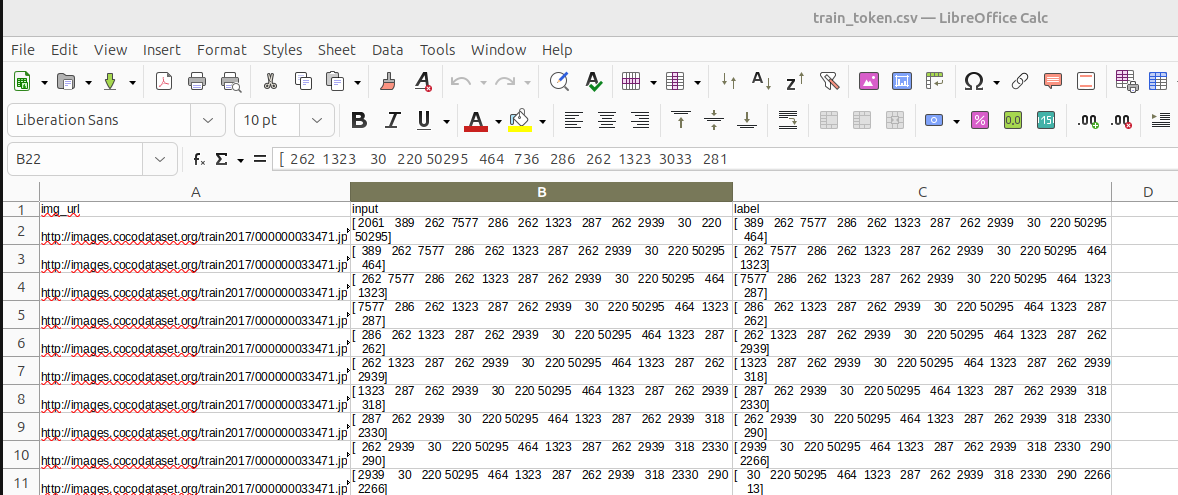

In [ ]:
# gpt like training dataset
# The dataset involves pairing image URLs with question-answer (Q-A) token sequences for training.
# img_url: URL of the image.
# input: Input token sequence (question + part of the answer).
# label: Target token sequence (shifted version of the input to predict the next token).

with open('train_token.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([['img_url','input','label']])

train_data_temp = []
r = 1
for df in data_instruct150_flatten:
  # image_url = df[0]: Extracts the image URL from the first element of the tuple.
  # image_q = df[1] + ' [QA]': Appends the custom [QA] token to the question string (df[1]).
  # image_a = df[2] + tokenizer.eos_token: Appends the end-of-sequence token (tokenizer.eos_token) to the answer string (df[2]).
  image_url = df[0]
  image_q   = df[1] + ' [QA]'
  image_a   = df[2] +  tokenizer.eos_token
  #print(image_q)
  #print(image_a)

  # tokenise
  # ques_token: Tokenizes the question using the tokenizer, returning it as a
  # PyTorch tensor (return_tensors="pt") without attention masks (return_attention_mask=False).
  # The squeeze(0) removes unnecessary dimensions, leaving a 1D tensor of token IDs for the question.
  # Similarly, tokenizes the answer and returns it as a 1D tensor of token IDs.
  ques_token = tokenizer(image_q, return_tensors="pt", return_attention_mask=False)['input_ids'].squeeze(0)
  ans_token  = tokenizer(image_a, return_tensors="pt", return_attention_mask=False)['input_ids'].squeeze(0)

  #print(ques_token)
  #print(ans_token)
  #break

  # context_length = len(ques_token): Stores the length of the question token sequence (which will be used later to extract subsequences).
  context_length = len(ques_token)
  # combo_q_a = torch.cat([ques_token, ans_token]): Concatenates the question and answer tokens into a single tensor called combo_q_a,
  # which represents the combined input and output for training.
  combo_q_a = torch.cat( [ques_token,ans_token])

  # for al in range(len(ans_token)):: Loops through each token in the answer sequence.
  # For each iteration, a sliding window is applied to generate input-label pairs.
  for al in range(len(ans_token)):
    # Creates an input sequence by extracting context_length tokens starting at index al.
    input = combo_q_a[al : al + context_length].numpy()
    # Creates a label sequence by shifting the input sequence by one token (used to predict the next token).
    label = combo_q_a[al + 1 : al + context_length + 1].numpy()
    # Appends the image_url, input, and label as a list to the train_data_temp list.
    train_data_temp.append([image_url,input,label])

    # When train_data_temp contains 100,000 entries, the data is written to the CSV file in batches to avoid memory overflow.
    # Writes all the rows in train_data_temp to the CSV file.
    if len(train_data_temp) >= 100000: # write to the file
       print(f"Writing to disk after {r * 100000} rows")
       r += 1
       with open('train_token.csv', 'a', newline='') as file:
          writer = csv.writer(file)
          writer.writerows(train_data_temp)
       train_data_temp = []

Writing to disk after 100000 rows
Writing to disk after 200000 rows
Writing to disk after 300000 rows
Writing to disk after 400000 rows
Writing to disk after 500000 rows
Writing to disk after 600000 rows
Writing to disk after 700000 rows
Writing to disk after 800000 rows
Writing to disk after 900000 rows
Writing to disk after 1000000 rows
Writing to disk after 1100000 rows
Writing to disk after 1200000 rows
Writing to disk after 1300000 rows
Writing to disk after 1400000 rows
Writing to disk after 1500000 rows
Writing to disk after 1600000 rows
Writing to disk after 1700000 rows
Writing to disk after 1800000 rows
Writing to disk after 1900000 rows
Writing to disk after 2000000 rows
Writing to disk after 2100000 rows
Writing to disk after 2200000 rows
Writing to disk after 2300000 rows
Writing to disk after 2400000 rows
Writing to disk after 2500000 rows
Writing to disk after 2600000 rows
Writing to disk after 2700000 rows
Writing to disk after 2800000 rows
Writing to disk after 2900000

Step 3 - PYTORCH DATASET AND DATALOADER TESTING

In [ ]:
df_data = pd.read_csv('train_token.csv')
df_data.head(15)

,img_url,input,label
0,http://images.cocodataset.org/train2017/000000...,[ 2061 389 262 7577 286 262 1323 2...,[ 389 262 7577 286 262 1323 287 2...
1,http://images.cocodataset.org/train2017/000000...,[ 389 262 7577 286 262 1323 287 2...,[ 262 7577 286 262 1323 287 262 29...
2,http://images.cocodataset.org/train2017/000000...,[ 262 7577 286 262 1323 287 262 29...,[ 7577 286 262 1323 287 262 2939 ...
3,http://images.cocodataset.org/train2017/000000...,[ 7577 286 262 1323 287 262 2939 ...,[ 286 262 1323 287 262 2939 30 2...
4,http://images.cocodataset.org/train2017/000000...,[ 286 262 1323 287 262 2939 30 2...,[ 262 1323 287 262 2939 30 220 502...
5,http://images.cocodataset.org/train2017/000000...,[ 262 1323 287 262 2939 30 220 502...,[ 1323 287 262 2939 30 220 50295 4...
6,http://images.cocodataset.org/train2017/000000...,[ 1323 287 262 2939 30 220 50295 4...,[ 287 262 2939 30 220 50295 464 13...
7,http://images.cocodataset.org/train2017/000000...,[ 287 262 2939 30 220 50295 464 13...,[ 262 2939 30 220 50295 464 1323 2...
8,http://images.cocodataset.org/train2017/000000...,[ 262 2939 30 220 50295 464 1323 2...,[ 2939 30 220 50295 464 1323 287 2...
9,http://images.cocodataset.org/train2017/000000...,[ 2939 30 220 50295 464 1323 287 2...,[ 30 220 50295 464 1323 287 262 29...


In [ ]:
df_data[0:1]

,img_url,input,label
0,http://images.cocodataset.org/train2017/000000...,[ 2061 389 262 7577 286 262 1323 2...,[ 389 262 7577 286 262 1323 287 2...


In [ ]:
for i in (df_data[0:1]['input']):
    print(i)
for i in (df_data[0:1]['label']):
    print(i)

[ 2061   389   262  7577   286   262  1323   287   262  2939    30   220
 50295]
[  389   262  7577   286   262  1323   287   262  2939    30   220 50295
   464]


In [ ]:
# llavadataset, which is used to load and process a question-answer dataset (likely for vision-language models) that combines image data with textual inputs and labels.
class llavadataset(Dataset):
  # This allows the dataset to be used in conjunction with PyTorch's DataLoader to load batches of data for model training or inference.
  def __init__(self, qa_dataset, phi_model_name, clip_model_name, tokenizer):
    self.processor  = AutoProcessor.from_pretrained(clip_model_name)
    self.qa_dataset = qa_dataset

  # It returns the number of rows (or examples) in qa_dataset
  def __len__(self):
    return self.qa_dataset.shape[0]

  def __getitem__(self, idx):
    # to access a single item from the dataset by its index (idx)
    # a tuple of three items: the processed image, the question tokens, and the answer tokens.
    img_url = self.qa_dataset.img_url[idx]
    ques    = torch.tensor(np.array(np.matrix(self.qa_dataset.input[idx]))[0])
    ans     = torch.tensor(np.array(np.matrix(self.qa_dataset.label[idx]))[0])

    # image load
    # Loads the image from the web using the image URL
    image_load = Image.open(requests.get(img_url,stream=True).raw)
    # preprocesses the image using the processor (self.processor) from the CLIP model.
    image_processed = self.processor(images=image_load, return_tensors="pt") ['pixel_values']
    # Removes the first dimension (batch size of 1) from the tensor,
    image_processed = image_processed.squeeze(0)
    return(image_processed , ques, ans)

In [ ]:
clip_model_name = "openai/clip-vit-base-patch32"
csv_file = 'train_token.csv'
qa_dataset = pd.read_csv(csv_file)
# call to llava_dataset for preprocessing
llava_dataset = llavadataset(qa_dataset, phi_model_name, clip_model_name, tokenizer)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
llava_dataset[0]

(tensor([[[ 1.1858,  1.1566,  1.1274,  ...,  1.3902,  1.3756,  1.1712],
          [ 1.2588,  1.2296,  1.1858,  ...,  1.4048,  1.2150,  1.2734],
          [ 1.4194,  1.3318,  1.2880,  ...,  1.3610,  1.1128,  1.3756],
          ...,
          [-0.4346, -0.3762, -0.3762,  ...,  0.8209,  0.7041,  0.9522],
          [-0.4200, -0.4054, -0.3908,  ...,  0.1493,  0.1639,  0.1055],
          [-0.4346, -0.4346, -0.3908,  ...,  0.2223,  0.1493,  0.1347]],
 
         [[ 1.4145,  1.3695,  1.3395,  ...,  1.6397,  1.6247,  1.3995],
          [ 1.4596,  1.4446,  1.3995,  ...,  1.6397,  1.4446,  1.5046],
          [ 1.5646,  1.4896,  1.4295,  ...,  1.5946,  1.3395,  1.6096],
          ...,
          [-0.4014, -0.3264, -0.3264,  ...,  0.9793,  0.7542,  1.0393],
          [-0.3564, -0.3414, -0.3264,  ...,  0.2439,  0.2289,  0.1839],
          [-0.3714, -0.3714, -0.3264,  ...,  0.2439,  0.1989,  0.1839]],
 
         [[ 1.7904,  1.7904,  1.7477,  ...,  1.9895,  1.9610,  1.7477],
          [ 1.8473,  1.8331,


Step 4 - SAMPLE VALIDATION DATA

In [ ]:
# Opening JSON file - instruct150k
f = open('llava_instruct_150k.json')

# returns JSON object as
# a dictionary
data = json.load(f)

In [ ]:
# create input pickle file by flattening the data
data_instruct150_sample_val_flatten = []
r = 0

for a_idx,d in enumerate(data):
    image = d['image']
    image_url = 'http://images.cocodataset.org/train2017/' + image
    conv_iter = iter( d['conversations'])
    for i in conv_iter:
      gpt_ans = next(conv_iter)
      if len(gpt_ans['value']) > 200: # filter out too long answers
          continue
      if i['from'] == 'human' and gpt_ans['from'] == 'gpt':
        image_q   = i['value'].replace('<image>\n','').replace('\n<image>','') + ' [QA]'
        image_a   = gpt_ans['value'] +  tokenizer.eos_token
        data_instruct150_sample_val_flatten.append([image_url, image_q, image_a ])

    if a_idx % 10000 == 0:
      print(f"{10000 * r} processed")
      r += 1
      if r >= 2:
        break


0 processed
10000 processed


In [ ]:
data_instruct150_sample_val_flatten[123]


['http://images.cocodataset.org/train2017/000000432526.jpg',
 'What are the skiers doing on the slope? [QA]',
 'The skiers have stopped on the side of the slope and are posing for a photo.<|endoftext|>']

In [ ]:
with open('sample_val_data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([['img_url','q','a']])

# data
with open('sample_val_data.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data_instruct150_sample_val_flatten)
